In [1]:
import pandas
import konlpy
import gensim
import numpy as np
import tensorflow as tf

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

2024-11-27 21:37:47.070684: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.0.3
0.6.0
4.3.3


##  1. 데이터 준비와 확인

In [2]:
import pandas as pd

train = pd.read_table('/home/mjun/ratings_train.txt')
test = pd.read_table('/home/mjun/ratings_test.txt')

display(train.head(), test.head())

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [3]:
display(train.info(), test.info()) # train 5개 nan, test 3개 nan

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        50000 non-null  int64 
 1   document  49997 non-null  object
 2   label     50000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.1+ MB


None

None

In [4]:
# nan값 확인 - index
train.loc[train[train.document.isnull()].index]

,id,document,label
25857,2172111,NaN,1
55737,6369843,NaN,1
110014,1034280,NaN,0
126782,5942978,NaN,0
140721,1034283,NaN,0


In [5]:
# 중복 데이터 확인
train[train.duplicated()]

,id,document,label


## 2. 데이터로더 구성

실습 때 다루었던 IMDB 데이터셋은 텍스트를 가공하여 imdb.data_loader() 메서드를 호출하면 숫자 인덱스로 변환된 텍스트와 word_to_index 딕셔너리까지 친절하게 제공합니다.\
그러나 이번에 다루게 될 nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일로 이루어져 있습니다. \
이것을 읽어서 imdb.data_loader()와 동일하게 동작하는 자신만의 data_loader를 만들어 보는 것으로 시작합니다.\
data_loader 안에서는 다음을 수행해야 합니다.

- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

In [6]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train, test) 


In [7]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [8]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 3. 모델 구성을 위한 데이터 분석 및 가공

- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

**데이터셋 내 문장 길이 분포**

In [9]:
# 데이터셋 내 문장 길이 분포
total_data_text = list(X_train) + list(X_test)
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {:.2f}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))




문장길이 평균 :  15.971024731364448
문장길이 최대 :  116
문장길이 표준편차 :  12.84408055468762
pad_sequences maxlen :  41
전체 문장의 0.93%가 maxlen 설정값 이내에 포함됩니다. 


In [10]:
# <PAD> 토큰 추가
if "<PAD>" not in word_to_index:
    word_to_index["<PAD>"] = 0
    
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


## 4. 모델 구성 및 validation set 구성

- 모델은 3가지 이상 다양하게 구성하여 실험해 보세요.

In [11]:
from sklearn.model_selection import train_test_split

# 검증 셋 생성
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")

Training set shape: (116945, 41)
Validation set shape: (29237, 41)


In [12]:
# LSTM, CNN, FFN 모델 생성
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# LSTM 모델
model_lstm = Sequential([
    Embedding(input_dim=len(word_to_index)+1, output_dim=128, input_length=maxlen),
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 41, 128)           1279872   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 1329345 (5.07 MB)
Trainable params: 1329345 (5.07 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2024-11-27 21:38:02.232972: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9621 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:19:00.0, compute capability: 7.5
2024-11-27 21:38:02.233854: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9621 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5
2024-11-27 21:38:02.234429: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 9621 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:67:00.0, compute capability: 7.5
2024-11-27 21:38:02.234845: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 9604 MB memory:  -> device: 3, name: NVIDIA GeForce RTX

In [13]:
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D

# CNN 모델
model_cnn = Sequential([
    Embedding(input_dim=len(word_to_index)+1, output_dim=128, input_length=maxlen),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   


 embedding_1 (Embedding)     (None, 41, 128)           1279872   
                                                                 
 conv1d (Conv1D)             (None, 37, 128)           82048     
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1370241 (5.23 MB)
Trainable params: 1370241 (5.23 MB)
Non-trainable params: 0 (0.00 Byte)
______________________________________

In [14]:
from tensorflow.keras.layers import Flatten

# Fully Connected NN
model_fc = Sequential([
    Embedding(input_dim=len(word_to_index)+1, output_dim=128, input_length=maxlen),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_fc.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_fc.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 41, 128)           1279872   
                                                                 
 flatten (Flatten)           (None, 5248)              0         
                                                                 
 dense_3 (Dense)             (None, 64)                335936    
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1615873 (6.16 MB)
Trainable params: 1615873 (6.16 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## 5. 모델 훈련 개시

In [15]:
epochs = 20

history_lstm = model_lstm.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=64,
    epochs=epochs,
    verbose=1
)    

Epoch 1/20


2024-11-27 21:38:06.458511: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8801
2024-11-27 21:38:07.400144: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f2c9801dbf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-27 21:38:07.400223: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2024-11-27 21:38:07.400247: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2024-11-27 21:38:07.400266: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (2): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2024-11-27 21:38:07.400284: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (3): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2024-11-27 21:38:07.415090: I tensorflow/compiler/mlir/te

1828/1828 [==============================] - 78s 40ms/step - loss: 0.4183 - accuracy: 0.8004 - val_loss: 0.3339 - val_accuracy: 0.8565
Epoch 2/20
1828/1828 [==============================] - 24s 13ms/step - loss: 0.3034 - accuracy: 0.8727 - val_loss: 0.3212 - val_accuracy: 0.8631
Epoch 3/20
1828/1828 [==============================] - 20s 11ms/step - loss: 0.2619 - accuracy: 0.8918 - val_loss: 0.3333 - val_accuracy: 0.8642
Epoch 4/20
1828/1828 [==============================] - 23s 13ms/step - loss: 0.2263 - accuracy: 0.9092 - val_loss: 0.3613 - val_accuracy: 0.8575
Epoch 5/20
1828/1828 [==============================] - 21s 11ms/step - loss: 0.1970 - accuracy: 0.9233 - val_loss: 0.3888 - val_accuracy: 0.8540
Epoch 6/20
1828/1828 [==============================] - 20s 11ms/step - loss: 0.1701 - accuracy: 0.9337 - val_loss: 0.4548 - val_accuracy: 0.8547
Epoch 7/20
1828/1828 [==============================] - 19s 11ms/step - loss: 0.1480 - accuracy: 0.9430 - val_loss: 0.4844 - val_accura

In [16]:
# CNN 모델 학습
history_cnn = model_cnn.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=64,
    epochs=epochs,
    verbose=1
)


Epoch 1/20
1828/1828 [==============================] - 38s 18ms/step - loss: 0.3810 - accuracy: 0.8294 - val_loss: 0.3217 - val_accuracy: 0.8606
Epoch 2/20
1828/1828 [==============================] - 15s 8ms/step - loss: 0.2692 - accuracy: 0.8896 - val_loss: 0.3229 - val_accuracy: 0.8627
Epoch 3/20
1828/1828 [==============================] - 15s 8ms/step - loss: 0.1861 - accuracy: 0.9269 - val_loss: 0.3829 - val_accuracy: 0.8565
Epoch 4/20
1828/1828 [==============================] - 13s 7ms/step - loss: 0.1154 - accuracy: 0.9564 - val_loss: 0.5124 - val_accuracy: 0.8521
Epoch 5/20
1828/1828 [==============================] - 14s 8ms/step - loss: 0.0784 - accuracy: 0.9697 - val_loss: 0.5614 - val_accuracy: 0.8475
Epoch 6/20
1828/1828 [==============================] - 13s 7ms/step - loss: 0.0585 - accuracy: 0.9781 - val_loss: 0.7308 - val_accuracy: 0.8444
Epoch 7/20
1828/1828 [==============================] - 14s 7ms/step - loss: 0.0480 - accuracy: 0.9817 - val_loss: 0.7628 - val_a

In [17]:
# Fully Connected NN 학습
history_fc = model_fc.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=64,
    epochs=epochs
)

Epoch 1/20
1828/1828 [==============================] - 34s 18ms/step - loss: 0.4029 - accuracy: 0.8155 - val_loss: 0.3573 - val_accuracy: 0.8428
Epoch 2/20
1828/1828 [==============================] - 13s 7ms/step - loss: 0.2952 - accuracy: 0.8748 - val_loss: 0.3841 - val_accuracy: 0.8369
Epoch 3/20
1828/1828 [==============================] - 12s 6ms/step - loss: 0.2085 - accuracy: 0.9141 - val_loss: 0.4616 - val_accuracy: 0.8330
Epoch 4/20
1828/1828 [==============================] - 11s 6ms/step - loss: 0.1470 - accuracy: 0.9389 - val_loss: 0.5797 - val_accuracy: 0.8276
Epoch 5/20
1828/1828 [==============================] - 12s 7ms/step - loss: 0.1178 - accuracy: 0.9520 - val_loss: 0.7446 - val_accuracy: 0.8188
Epoch 6/20
1828/1828 [==============================] - 11s 6ms/step - loss: 0.0976 - accuracy: 0.9592 - val_loss: 0.8983 - val_accuracy: 0.8191
Epoch 7/20
1828/1828 [==============================] - 12s 6ms/step - loss: 0.0862 - accuracy: 0.9634 - val_loss: 1.0600 - val_a

In [18]:
# lstm,cnn,fc 모델 평가
lstm_results = model_lstm.evaluate(X_test,  y_test, verbose=2)
cnn_results = model_cnn.evaluate(X_test,  y_test, verbose=2)
fc_results = model_fc.evaluate(X_test,  y_test, verbose=2)

print(lstm_results)
print(cnn_results)
print(fc_results)

1537/1537 - 7s - loss: 0.8371 - accuracy: 0.8407 - 7s/epoch - 4ms/step
1537/1537 - 5s - loss: 1.4094 - accuracy: 0.8403 - 5s/epoch - 3ms/step
1537/1537 - 4s - loss: 1.9812 - accuracy: 0.8064 - 4s/epoch - 3ms/step
[0.8370924592018127, 0.8406941294670105]
[1.4093517065048218, 0.8403279185295105]
[1.981167197227478, 0.8064161539077759]


In [19]:
history_lstm_dict = history_lstm.history
print(history_lstm_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [20]:
history_cnn_dict = history_cnn.history
print(history_cnn_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [21]:
history_fc_dict = history_fc.history
print(history_fc_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


## 6. Loss, Accuracy 그래프 시각화

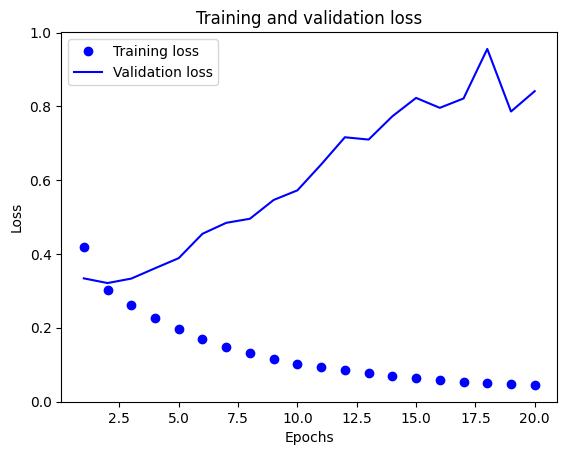

In [25]:
import matplotlib.pyplot as plt

acc = history_lstm_dict['accuracy']
val_acc = history_lstm_dict['val_accuracy']
loss = history_lstm_dict['loss']
val_loss = history_lstm_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

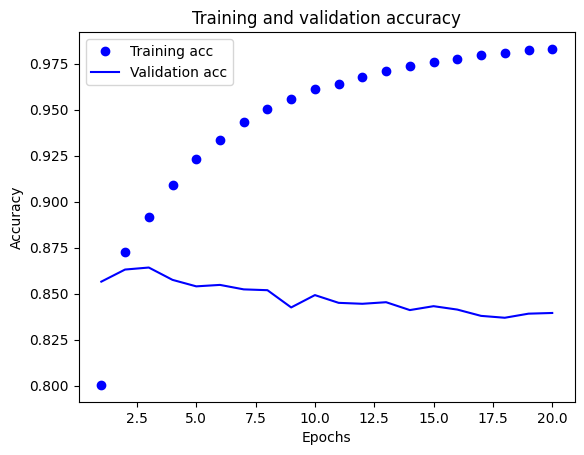

In [26]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

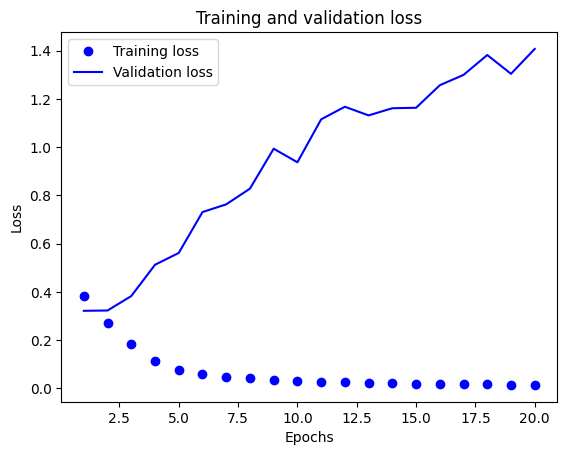

In [27]:
acc = history_cnn_dict['accuracy']
val_acc = history_cnn_dict['val_accuracy']
loss = history_cnn_dict['loss']
val_loss = history_cnn_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

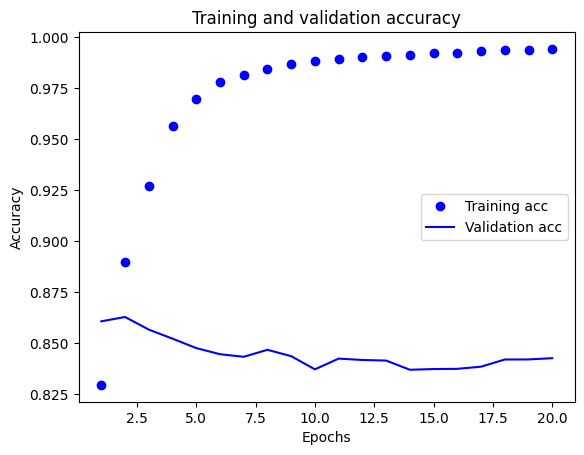

In [28]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

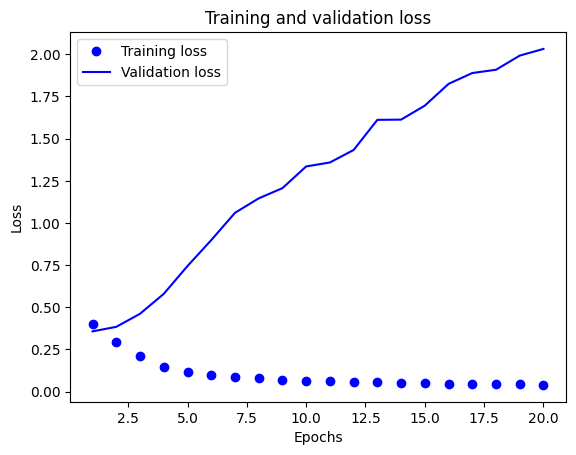

In [29]:
import matplotlib.pyplot as plt

acc = history_fc_dict['accuracy']
val_acc = history_fc_dict['val_accuracy']
loss = history_fc_dict['loss']
val_loss = history_fc_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

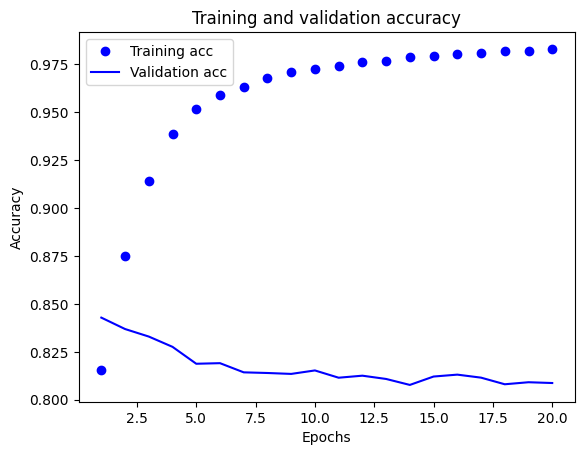

In [30]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

**3가지 모델 모두 2~ 3에폭 사이에서 과적합 발생**

## 7. 학습된 Embedding 레이어 분석

In [ ]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word2vec_file_path = '/home/mjun/word2vec_ko.model'
word2vec = Word2VecKeyedVectors.load(word2vec_file_path)


In [40]:
# 단어 벡터 가져오기
vocab_size = 10000  # 어휘 사전의 크기
word_vector_dim = 100  # 워드 벡터의 차원수

# 임베딩 행렬 초기화
embedding_matrix = np.zeros((vocab_size, word_vector_dim))

In [41]:
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec.wv:
        embedding_matrix[i] = word2vec.wv[index_to_word[i]]

In [44]:
from tensorflow.keras.initializers import Constant
# 모델 구성
model_lstm_emb = tf.keras.Sequential()
model_lstm_emb.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model_lstm_emb.add(tf.keras.layers.LSTM(64))
model_lstm_emb.add(tf.keras.layers.Dropout(0.5))
model_lstm_emb.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_lstm_emb.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 41, 100)           1000000   
                                                                 
 lstm_2 (LSTM)               (None, 64)                42240     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1042305 (3.98 MB)
Trainable params: 1042305 (3.98 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [45]:
# 학습의 진행
model_lstm_emb.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs = 20

history_lstm_emb = model_lstm_emb.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=64,
    epochs=epochs,
    verbose=1
)    

Epoch 1/20
1828/1828 [==============================] - 41s 22ms/step - loss: 0.4331 - accuracy: 0.7997 - val_loss: 0.3509 - val_accuracy: 0.8485
Epoch 2/20
1828/1828 [==============================] - 22s 12ms/step - loss: 0.3310 - accuracy: 0.8596 - val_loss: 0.3315 - val_accuracy: 0.8531
Epoch 3/20
1828/1828 [==============================] - 22s 12ms/step - loss: 0.2961 - accuracy: 0.8771 - val_loss: 0.3243 - val_accuracy: 0.8617
Epoch 4/20
1828/1828 [==============================] - 20s 11ms/step - loss: 0.2684 - accuracy: 0.8901 - val_loss: 0.3228 - val_accuracy: 0.8637
Epoch 5/20
1828/1828 [==============================] - 20s 11ms/step - loss: 0.2441 - accuracy: 0.9016 - val_loss: 0.3432 - val_accuracy: 0.8578
Epoch 6/20
1828/1828 [==============================] - 20s 11ms/step - loss: 0.2222 - accuracy: 0.9109 - val_loss: 0.3619 - val_accuracy: 0.8632
Epoch 7/20
1828/1828 [==============================] - 20s 11ms/step - loss: 0.2025 - accuracy: 0.9204 - val_loss: 0.3597 -

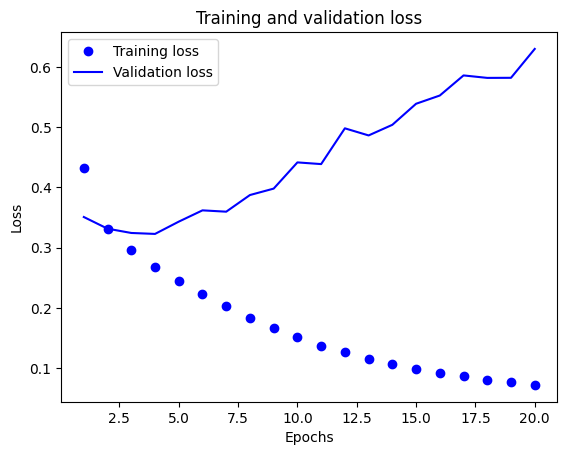

In [46]:
history_dict = history_lstm_emb.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

에폭 2.5 ~ 5 사이부터 과적합 발생

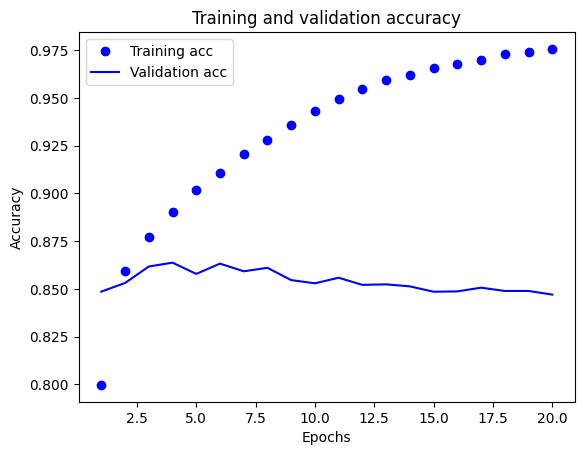

In [47]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [49]:
results = model_lstm_emb.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 7s - loss: 0.6421 - accuracy: 0.8439 - 7s/epoch - 4ms/step
[0.6420589089393616, 0.8439489603042603]


## 회고

- accuracy가 85% 달성 못하였느데 가장 좋게 나온 lstm 모델에 layer을 깊에 쌓아서 추가 실험을 해봐야겠다
- 할 일은 제때에 해야한다... 밀리면 답이없다